## Batch Normalization

训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。
- 损失出现在最后，顶部的层训练较快；
- 数据在最底部
  - 底部的层训练较慢
  - 底部层一变化，所有都得跟着变
  - 最后的那些层需要重新学习很多次，导致收敛变慢
- 能否在学习底部层的时候，避免变化顶部层？

### 1、训练深层神经网络

#### 1.1、挑战

- 数据预处理的方式通常会对最终结果产生巨大影响：比如对输入数据做标准化，能很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一；
- 对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：
  - 不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测；
  - 批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。
- 更深层的网络很复杂，容易过拟合。 这意味着正则化变得更加重要。

#### 1.2、批量归一化

批量规范化应用于单个可选层（也可以应用到所有层）：
- 按mini batch对数据做规范化，减去其均值并除以其标准差：（小常量$\epsilon$保证永远不会除以0）
  $$
  \mu_B = \frac{1}{|B|}\sum_{i\in B}x_i ~~ and ~~ \sigma^2_{B} = \frac{1}{|B|}\sum_{i\in B}(x_i - \mu_B)^2 + \epsilon
  $$
- 应用比例系数$\gamma$和比例偏移$\beta$（可学习的参数）：
  $$
  x_{i+1} = \gamma \frac{x_i - \mu_B}{\sigma_B} + \beta
  $$
只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的，批量大小的选择可能比没有批量规范化时更重要。

另外，批量规范化图层在“训练模式”（通过小批量统计数据规范化）和“预测模式”（通过数据集统计规范化）中的功能不同。 在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。 而在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和方差。

### 2、批量规范化层

- 可学习的参数为$\gamma$和$\beta$；
- 作用在：
  - 全连接层和卷积层的输出上，激活函数之前；
  - 全连接层和卷积层的输入上；
- 对全连接层，作用在特征维；
- 对卷积层，作用在通道维。

### 3、争议

batch normalization在做什么？
- 最初论文是想用它来减少内部协变量的偏移；
- 后续有论文指出，它可能就是通过在每个小批量里加入噪音（小批量上的均值和标准差，实际上与整体的均值和标准差有一定的误差），来控制模型复杂度；
- 因此没必要与丢弃法混合使用；
  
用起来好用，但很难解释为什么好用。

### 4、从零实现

In [1]:
import torch
from torch import nn
import sys
sys.path.append('..')
import utils
import d2l

实现batch规范化函数：

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    '''
    批量规范化函数

    Parameters:
    - X: 批量样本
    - gamma: 比例系数，可学习
    - beta: 比例偏移，可学习
    - moving_mean: 指数加权移动平均，预测均值
    - moving_var: 指数加权移动平均，预测方差
    - eps: 避免除0，加的一个小常量
    - momentum: 用于更新moving_mean, moving_var的
    '''
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，（batch, feature），计算特征维上的均值和方差
            mean = X.mean(dim=0)                    # 按行求
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，（batch, channel, height, width），计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

BatchNorm图层

In [3]:
class BatchNorm(nn.Module):
    '''
    批量规范化图层

    Parameters:
    - num_features: 全连接层的输出数量或卷积层的输出通道数
    - num_dims: 2表示全连接层，4表示卷积层
    '''
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 5、应用BatchNorm于LeNet模型

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.263, train acc 0.903, test acc 0.872
30180.9 examples/sec on cuda:0


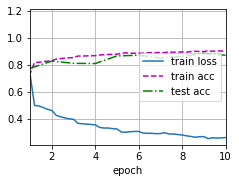

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data')
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu())

### 6、简洁实现

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.263, train acc 0.902, test acc 0.883
45716.7 examples/sec on cuda:0


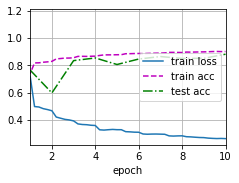

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data')
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu())

### 7、小结

- 批量规范化，标准化小批量中的均值和方差，然后学习出适合的偏移和缩放；
- 可以加速收敛速度，但一般不改变模型精度；